<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Distributed computing with MPI

## Contents


In this notebook, we will learn the basics of parallel computing using the Message Passing Interface (MPI) from Julia. In particular, we will learn:

- How to run parallel MPI code in Julia
- How to use basic collective communication directives
- How to use basic point-to-point communication directives

For further information on how to use MPI from Julia see https://github.com/JuliaParallel/MPI.jl


## What is MPI ?

- MPI stands for the "Message Passing Interface"
- It is the gold-standard for distributed computing in HPC systems since the 90s
- It is a standardized library specification for communication between parallel processes in distributed memory systems.
- It is huge: the MPI standard has above 1k pages (see https://www.mpi-forum.org/docs/mpi-4.0/mpi40-report.pdf)
- There are several implementations of this standard (OpenMPI, MPICH, IntelMPI)
- The interface is in C and FORTRAN (C++ was deprecated)
- There are Julia bindings via the package MPI.jl

### Hello-world example

In [ ]:
] add MPI

In [ ]:
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
println("Hello, I am process $rank of $nranks processes!")

## Running MPI code

### Execution model

- MPI programs are typically run with a Single Program Multiple Data (SPMD) model
- But the standard supports Multiple Program Multiple Data (MPMD)

### Creating MPI processes (aka ranks)

- MPI processes are created with the driver program `mpiexec`
- `mpiexec` takes an application and runs it on different ranks
- The application calls MPI directives to communicate between these ranks
- The application can be Julia running your script in particular.


 <div>
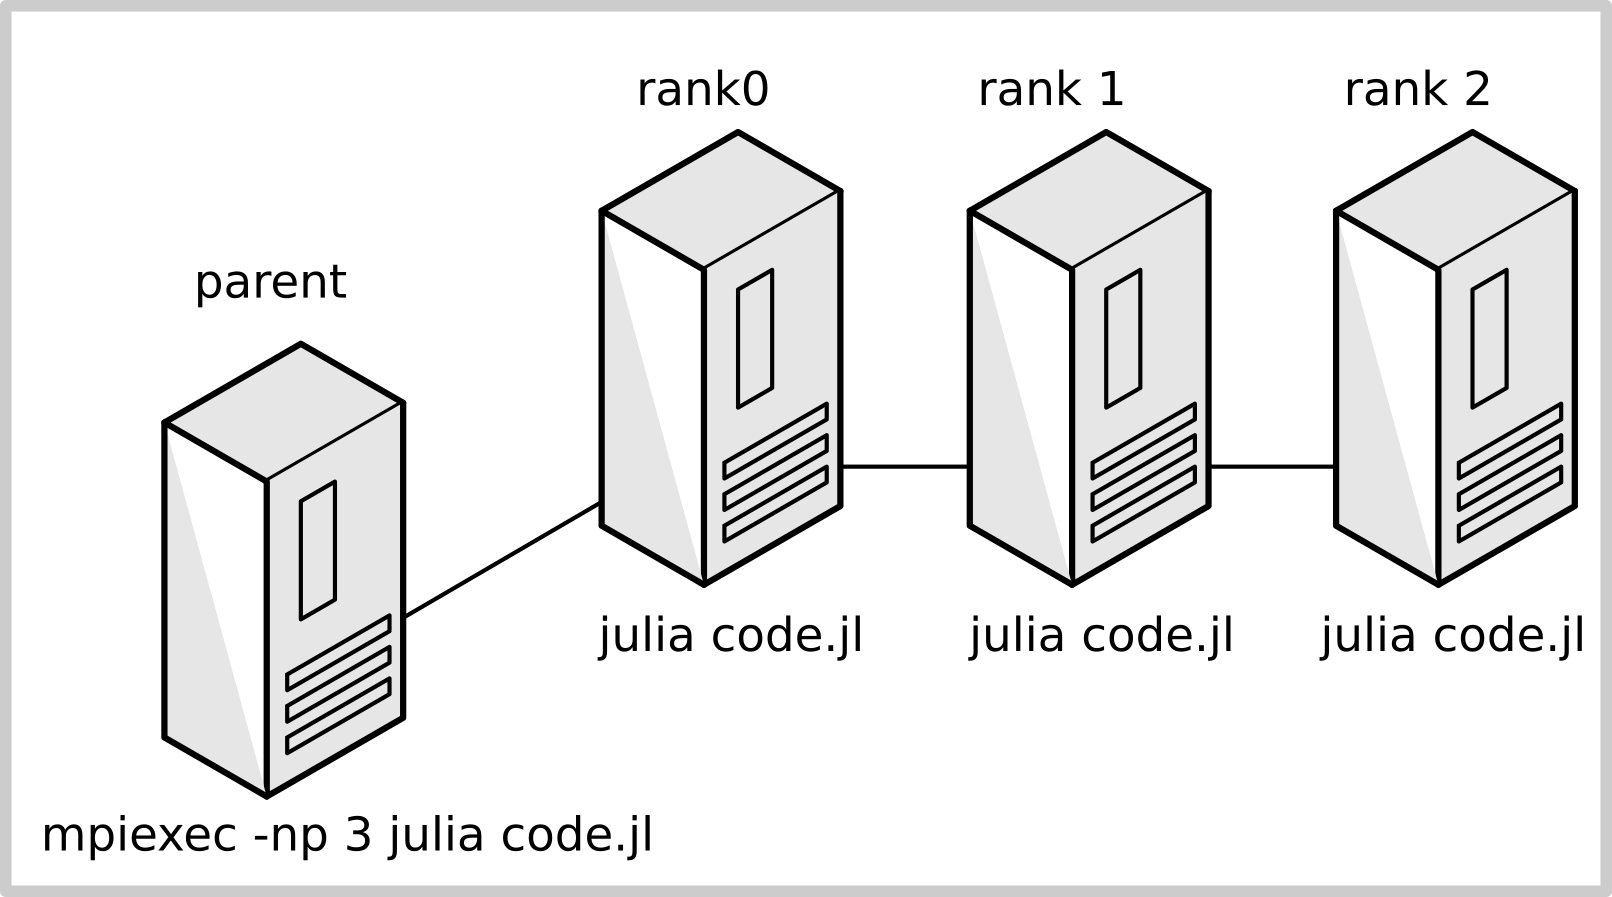
</div>

### Hello world

Julia code needs typically needs to be in a file to run in with MPI. Let's us write our hello world in a file:

In [ ]:
code = raw"""
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
println("Hello, I am process $rank of $nranks processes!")
"""
filename = tempname()*".jl"
write(filename,code);

Now, we can run it

In [ ]:
using MPI
mpiexec(cmd->run(`$cmd -np 4 julia --project=. $filename`));

Note that function mpiexec provided by MPI.jl is a convenient way of accessing the mpiexec program that matches the MPI installation used my Julia.

###  MPIClusterManagers 

- This package allows you to create Julia workers that can call MPI code
- Very useful to combine Distributed.jl and MPI.jl
- E.g., we can run MPI code interactively (from a notebook)
- Link: https://github.com/JuliaParallel/MPIClusterManagers.jl


 <div>
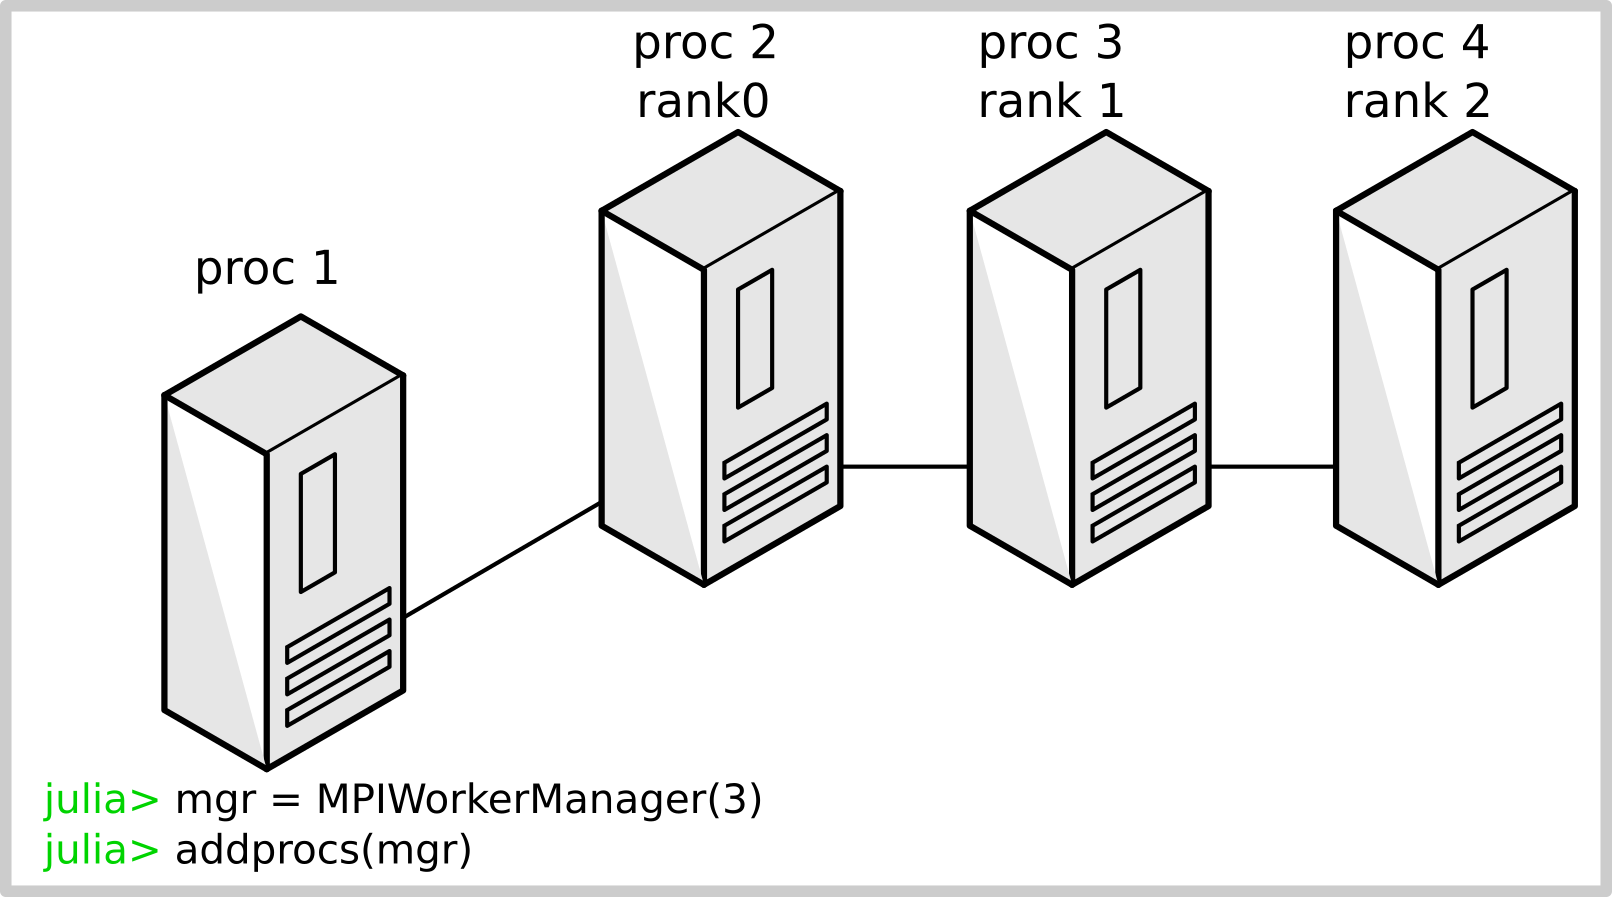
</div>

In [ ]:
] add MPIClusterManagers

In [1]:
using MPIClusterManagers
using Distributed
if procs() == workers()
    nranks = 3
    manager = MPIWorkerManager(nranks)
    addprocs(manager)
end

3-element Vector{Int64}:
 2
 3
 4

In [2]:
@everywhere workers() begin
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    println("Hello, I am process $rank of $nranks processes!")
end

      From worker 4:	Hello, I am process 2 of 3 processes!
      From worker 2:	Hello, I am process 0 of 3 processes!
      From worker 3:	Hello, I am process 1 of 3 processes!


## Collective communication

MPI provides collective communication functions for communication involving multiple processes. Some usual collective directives are:

- `MPI.Scatter`: Distributes data from one process to all processes.
- `MPI.Gather`: Gathers data from all processes to a single process.
- `MPI.Bcast`: Broadcasts data from one process to all processes.
- `MPI.Barrier`: Synchronizes all processes.

See more collective directives available from Julia here: https://juliaparallel.org/MPI.jl/stable/reference/collective/


### Scatter

In [ ]:
@everywhere workers() begin
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    rcv = Ref(0) 
    if rank == root
        snd = [10*(i+1) for i in 1:nranks]
        println("I am sending: $snd")
    else
        snd = nothing
    end    
    MPI.Scatter!(snd,rcv,comm;root)
    println("I have received: $(rcv[])")
end

### Gather

In [ ]:
@everywhere workers() begin
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    snd = 10*(rank+2)
    println("I am sending $snd")
    rcv = MPI.Gather(snd,comm;root)
    if rank == root
        println("I have received: $rcv")
    end
end

## Point-to-Point communication


MPI also provides point-to-point communication directives for arbitrary communication between processes. Point-to-point communications are two-sided: there is a sender and a receiver. Here, we will discuss these basic directives:

- `MPI.Isend`, and `MPI.Irecv!`

There are *Non-blocking directives*. MPI also offers blocking directives with different blocking behaviors (communication modes). Blocking communication will be discussed later in the course.



### Pingpong example

In [16]:
@everywhere workers() begin
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    snder = 0
    rcver = nranks-1
    buffer = Ref(0)
    if rank == snder
        msg = 10*(rank+2)
        println("I am sending: $msg")
        buffer[] = msg
        req = MPI.Isend(buffer,comm;dest=rcver,tag=0)
        MPI.Wait(req)
        req = MPI.Irecv!(buffer,comm,source=rcver,tag=0)
        MPI.Wait(req)
        msg = buffer[]
        println("I have received: $msg")
    end
    if rank == rcver
        req = MPI.Irecv!(buffer,comm,source=snder,tag=0)
        MPI.Wait(req)
        msg = buffer[]
        println("I have received: $msg")
        msg = msg*(rank+2)
        println("I am sending: $msg")
        buffer[] = msg
        req = MPI.Isend(buffer,comm;dest=snder,tag=0)
        MPI.Wait(req)
    end
end

      From worker 2:	I am sending: 20
      From worker 4:	I have received: 20
      From worker 4:	I am sending: 80
      From worker 2:	I have received: 80


Message Passing Interface (MPI) is a standardized and portable library specification for communication between parallel processes in distributed memory systems.


Julia offers a convenient way to work with MPI for creating efficient parallel and distributed applications. In this tutorial, you will learn how to use MPI from Julia to perform parallel computing tasks.

## MPI launches separate Julia instances
When you run an MPI-enabled Julia script, MPI takes care of spawning multiple instances of the Julia executable, each acting as a separate process. These workers can communicate with each other using MPI communication functions. This enables parallel processing and distributed computation. Here's a summary of how it works:

-- TODO: insert picture here --

-  **MPI Spawns Processes**: The `mpiexec` command launches multiple instances of the Julia executable, creating separate worker processes. In this example, 4 Julia workers are spawned.

-  **Worker Communication**: These workers can communicate with each other using MPI communication functions, allowing them to exchange data and coordinate actions.

- **Parallel Tasks**: The workers execute parallel tasks simultaneously, working on different parts of the computation to potentially speed up the process.


 


## Installing MPI.jl and MPIClusterManagers Packages
To use MPI in Julia, you'll need the MPI.jl package, and if you intend to run MPI programs in a Jupyter Notebook, you'll also need the MPIClusterManagers package. These packages provide the necessary bindings to the MPI library and cluster management capabilities. To install the packages, open a terminal and run the following commands:

In [ ]:
using Pkg
Pkg.add("MPI")
Pkg.add("MPIClusterManagers")

<div class="alert alert-block alert-info">
    <b>Tip:</b>
The package <code>MPI.jl</code> is the Julia interface to MPI. Note that it is not a MPI library by itself. It is just a thin wrapper between MPI and Julia. To use this interface, you need an actual MPI library installed in your system such as OpenMPI or MPICH. Julia downloads and installs a MPI library for you, but it is also possible to use a MPI library already available in your system. This is useful, e.g., when running on HPC clusters. See the documentation of <code>MPI.jl</code> for further details.
</div>

## Writing a HelloWorld MPI Program in Julia
Let's start by creating a simple MPI program that prints a message along with the rank of each worker. 

Create a new Julia script, for example, `mpi_hello_world.jl`:

```julia
using MPI

# Initialize MPI
MPI.Init()

# Get the default communicator (MPI_COMM_WORLD) for all processes
comm = MPI.COMM_WORLD

# Get the number of processes in this communicator
nranks = MPI.Comm_size(comm)

# Get the rank of the current process within the communicator
rank = MPI.Comm_rank(comm)

# Print a message with the rank of the current process
println("Hello, I am process $rank of $nranks processes!")

# Finalize MPI
MPI.Finalize()
```

### MPI Communicators
In MPI, a **communicator** is a context in which a group of processes can communicate with each other. `MPI_COMM_WORLD` is one of the MPI standard communicators, it represents all processes in the MPI program. Custom communicators can also be created to group processes based on specific requirements or logical divisions. 

The **rank** of a processor is a unique identifier assigned to each process within a communicator. It allows processes to distinguish and address each other in communication operations. 

## Running the HelloWorld MPI Program

To run MPI applications in parallel, you need a launcher like `mpiexec`. MPI codes written in Julia are not an exception to this rule. From the system terminal, you can run
```
$ mpiexec -np 4 mpi_hello_world.jl
```
In this command, `-np 4` specifies the desired number of processes. 
But it will probably not work since the version of `mpiexec` needs to match with the MPI version we are using from Julia. You can find the path to the `mpiexec` binary you need to use with these commands

```julia
julia> using MPI
julia> MPI.mpiexec_path
```

and then try again
```
$ /path/to/my/mpiexec -np 4 julia mpi_hello_world.jl
```
with your particular path.

However, this is not very convenient. Don't worry if you could not make it work! A more elegant way to run MPI code is from the Julia REPL directly, by using these commands:
```julia
julia> using MPI
julia> mpiexec(cmd->run(`$cmd -np 4 julia mpi_hello_world.jl`))
```

Now, you should see output from 4 ranks.


## Running MPI Programs in Jupyter Notebook with MPIClusterManagers
If you want to run your MPI code from a Jupyter Notebook, you can do so using the `MPIClusterManagers` package.

1. Load the packages and start an MPI cluster with the desired number of workers:

In [ ]:
using MPIClusterManagers
# Distributed package is needed for addprocs()
using Distributed

manager = MPIWorkerManager(4)
addprocs(manager)

2. Run your MPI code inside a `@mpi_do` block to execute it on the cluster workers:

In [ ]:
@mpi_do manager begin
    using MPI
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    println("Hello from process $rank")
end


MPI is automatically initialized and finalized within the `@mpi_do` block.

3. Remove processes when done:

In [ ]:
rmprocs(manager)

## Point-to-Point Communication with MPI
MPI provides point-to-point communication using blocking send and receiving functions `MPI.send`, `MPI.recv`; or their non-blocking versions `MPI.Isend`, and `MPI.Irecv!`. These functions allow individual processes to send and receive data between each other.

### Blocking communication

Let's demonstrate how to send and receive with an example:

```julia
using MPI

MPI.Init()

comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)

# Send and receive messages using blocking MPI.send and MPI.recv
if rank == 0
    data = "Hello from process $rank !"
    MPI.send(data, comm, dest=1)
elseif rank == 1
    received_data = MPI.recv(comm, source=0)
    println("Process $rank received: $received_data")
end

MPI.Finalize()
```

In this example, process 0 sends a message using `MPI.send`, and process 1 receives it using `MPI.recv`.

### Non-blocking communication

To demonstrate asynchronous communication, let's modify the example using `MPI.Isend` and `MPI.Irecv!`:

```julia
using MPI

MPI.Init()

comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)

# Asynchronous communication using MPI.Isend and MPI.Irecv!
if rank == 0
    data = "Hello from process $rank !"
    request = MPI.Isend(data, comm, dest=1)
    # Other computation can happen here
    MPI.Wait(request)
elseif rank == 1
    received_data = Array{UInt8}(undef, 50)  # Preallocate buffer
    request = MPI.Irecv!(received_data, comm, source=0)
    # Other computation can happen here
    MPI.Wait(request)
    println("Process $rank received: $(String(received_data))")
end

MPI.Finalize()
```

In this example, process 0 uses `MPI.Isend` to send the message asynchronously. This function returns immediately, allowing the sender process to continue its execution. However, the actual sending of data is done asynchronously in the background. Similar to `MPI.Isend`, `MPI.Irecv!` returns immediately, allowing the receiver process to continue executing. 

<div class="alert alert-block alert-warning">
<b>Important:</b> In asynchronous communication, always use <code>MPI.Wait()</code> to ensure the communication is finished before accessing the send or receive buffer.
</div>


## Collective Communication with MPI
MPI provides collective communication functions for communication involving multiple processes. Let's explore some of these functions:

- MPI.Gather: Gathers data from all processes to a single process.
- MPI.Scatter: Distributes data from one process to all processes.
- MPI.Bcast: Broadcasts data from one process to all processes.
- MPI.Barrier: Synchronizes all processes.


Let's illustrate the use of `MPI.Gather` and `MPI.Scatter` with an example:

```julia
# TODO: check if this runs correctly
using MPI
using Random

MPI.Init()

comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
size = MPI.Comm_size(comm)

# Root processor generates random data
data = rand(rank == 0 ? size * 2 : 0)

# Scatter data to all processes
local_data = Vector{Float64}(undef, 2)
MPI.Scatter!(data, local_data, comm, root=0)

# Compute local average
local_average = sum(local_data) / length(local_data)

# Gather local averages at the root processor
gathered_averages = Vector{Float64}(undef, size)
MPI.Gather!(local_average, gathered_averages, comm, root=0)

if rank == 0
    # Compute global average of sub-averages
    global_average = sum(gathered_averages) / size
    println("Global average: $global_average")
end

MPI.Finalize()
```

In [ ]:
using MPI
using Random

# TODO: check if this runs correctly

MPI.Init()

comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
size = MPI.Comm_size(comm)

# Root processor generates random data
data = rand(rank == 0 ? size * 2 : 0)

# Scatter data to all processes
local_data = Vector{Float64}(undef, 2)
MPI.Scatter!(data, local_data, comm, root=0)

# Compute local average
local_average = sum(local_data) / length(local_data)

# Gather local averages at the root processor
gathered_averages = Vector{Float64}(undef, size)
MPI.Gather!(local_average, gathered_averages, comm, root=0)

if rank == 0
    # Compute global average of sub-averages
    global_average = sum(gathered_averages) / size
    println("Global average: $global_average")
end

MPI.Finalize()

In this example, the root processor generates random data and then scatters it to all processes using MPI.Scatter. Each process calculates the average of its local data, and then the local averages are gathered using MPI.Gather. The root processor computes the global average of all sub-averages and prints it.

# License

TODO: replace link to website

This notebook is part of the course [Programming Large Scale Parallel Systems](http://localhost:8000/) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.